In [9]:
import numpy as np
from numpy import random
import pickle
import os
import pathlib

from Performance import DDR_Problem_Evaluation
ddr_eva = DDR_Problem_Evaluation()
from OLS import OLS_Related_Estimation
from DDR_Estimation import DDR_Method
from SPO import SPO_Plus_Method
from Data import DataSimulator
from Figure_Regret_H2H import Regret_H2H

## Generate Data

In [10]:
def generate_data(DataPath,iters,lower, upper, p, d, data_generation_process,
                  samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp):
    data_simu = DataSimulator()
    Data = {}
    for i in range(iters):
        # print("============== iteration = ",i,"==============")
        file_path = DataPath + "iter="+str(i) +"/"
        pathlib.Path(file_path).mkdir(parents=True, exist_ok=True)
        W_star = data_simu.generate_truth(lower, upper, p, d, data_generation_process) 
        Data[i] = data_simu.generate_samples(file_path,p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                            data_generation_process, x_dister, e_dister, xl, xu, xm, xv, bp) 
    return Data

## Oracle

In [11]:
def Implement_Oracle(iters,Data,data_generation_process,DataPath,A,b):
    cost_Oracle_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        cost_Oracle_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost_with_constr(z_test_ori,z_test_ori,z_test-z_test_ori,data_generation_process,False,A,b)
        # if i % 10 == 0:
        #     print(fold_name,",iteration = ",i,",c_oracle_without_noise = ",np.nanmean(cost_Oracle_wo_noise_all[i]))
    with open(DataPath+'cost_Oracle_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Oracle_wo_noise_all,tf)
    return cost_Oracle_wo_noise_all

## OLS

In [12]:
def Implement_OLS(iters,Data,data_generation_process,DataPath,A,b):
    ORE = OLS_Related_Estimation()
    cost_OLS_with_noise_all = {}; cost_OLS_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_ols, w0_ols, t_ols, obj_ols = ORE.OLS_Solver("",x_train, z_train)
        cost_pred = (W_ols @ x_test.T).T + w0_ols
        cost_OLS_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost_with_constr(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False,A,b)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",c_OLS_without_noise = ",np.nanmean(cost_OLS_wo_noise_all[i]))
    with open(DataPath+'cost_OLS_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_OLS_wo_noise_all,tf)
    return cost_OLS_wo_noise_all

In [13]:
def Implement_Ridge(iters,Data,data_generation_process,DataPath):

    ORE = OLS_Related_Estimation()
    cost_Ridge_with_noise_all = {}; cost_Ridge_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_ridge, w0_ridge, t_ridge = ORE.Ridge_Solver(x_train, z_train)
        cost_pred = (W_ridge @ x_test.T).T + w0_ridge
        cost_Ridge_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",c_Ridge_without_noise = ",np.nanmean(cost_Ridge_wo_noise_all[i]))

    with open(DataPath+'cost_Ridge_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Ridge_wo_noise_all,tf)

    return cost_Ridge_wo_noise_all

## DDR

In [14]:
def Implement_DDR(iters,Data,data_generation_process,DataPath,mu_all,lamb_all,A,b):
    DDR_Esti = DDR_Method()
    W_ddr_all = {}; w0_ddr_all = {}; obj_ddr_all = {}
    cost_DDR_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        cost_ddr_avg_tem = np.zeros((len(mu_all),len(lamb_all)))
        for mu_index in range(len(mu_all)):
            mu = mu_all[mu_index]
            for lamb_index in range(len(lamb_all)):
                lamb = lamb_all[lamb_index]
                W_ddr_all[i,mu,lamb], w0_ddr_all[i,mu,lamb] = DDR_Esti.DDR_Solver_with_Constr(x_train, z_train, mu, lamb,A,b)
                cost_pred = (W_ddr_all[i,mu,lamb] @ x_test.T).T + w0_ddr_all[i,mu,lamb]
                cost_DDR_wo_noise_all[i,mu,lamb] = ddr_eva.compute_DDR_out_of_sample_Cost_with_constr(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False,A,b)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",cost_DDR_wo_noise_all = ",np.nanmean(cost_DDR_wo_noise_all[i,mu,lamb]))
    with open(DataPath+'cost_DDR_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_DDR_wo_noise_all,tf)

    return cost_DDR_wo_noise_all

## SPO Plus

In [15]:
# def Implement_SPO_plus(iters,Data,data_generation_process,DataPath):
#     SPM = SPO_Plus_Method()
#     cost_SPO_with_noise_all = {}; cost_SPO_wo_noise_all = {}
#     for i in range(iters):
#         x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
#         y_train_opt = ddr_eva.decision_finder(z_train) #generates the optimal y from the training costs
#         W_spo, w0_spo, t_spo = SPM.SPO_Solver(x_train, z_train, y_train_opt)
#         cost_pred = (W_spo @ x_test.T).T + w0_spo
#         cost_SPO_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
#         # if i % 100 == 0:
#         #     print(fold_name,",iteration = ",i,",cost_SPO_wo_noise_all = ",np.nanmean(cost_SPO_wo_noise_all[i]))
#     with open(DataPath+'cost_SPO_wo_noise_all.pkl', "wb") as tf:
#         pickle.dump(cost_SPO_wo_noise_all,tf)
#     return cost_SPO_wo_noise_all

## Comparison

In [16]:
seed = 3
random.seed(seed)
iters = 100
samples_test = 10000
thres = 100000000
lower = 0
upper = 1
n_epsilon = 1
mis = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
bp = 7

d = 10
alpha = 1
samples_train = 100
p = 4

a = 3
A = np.random.uniform(-2,0,(a,d))
b = np.random.uniform(-1,0,a)

mu_all = np.round(np.arange(0.25,0.251,0.1),4)
lamb_all = np.round(np.arange(0.25,0.251,0.1),4)
data_generation_process = "DDR_Data_Generation"

current_directory = os.getcwd()
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(current_directory))))
DataPath = project_directory + "/Data_JOC_R1/DDR/Figure6/"
print("DataPath:", DataPath)
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/DDR/Figure6/


In [17]:
mu = mu_all[0]
lamb = lamb_all[0]

Data = generate_data(DataPath,iters,lower, upper, p, d, data_generation_process,
    samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp)

cost_Oracle_wo_noise_all = Implement_Oracle(iters,Data,data_generation_process,DataPath,A,b)
cost_OLS_wo_noise_all = Implement_OLS(iters,Data,data_generation_process,DataPath,A,b)
cost_DDR_wo_noise_all = Implement_DDR(iters,Data,data_generation_process,DataPath,mu_all,lamb_all,A,b)

win_ratio_ddr_ols_wo_noise = np.zeros(iters); cost_reduction_ddr_ols_wo_noise = np.zeros(iters); regret_reduction_ddr_ols_wo_noise = np.zeros(iters)
for i in range(iters):
    lbel, win_ratio_ddr_ols_wo_noise[i], cost_reduction_ddr_ols_wo_noise[i], regret_reduction_ddr_ols_wo_noise[i] = ddr_eva.cross_compare2plus(cost_DDR_wo_noise_all[i,mu,lamb],cost_OLS_wo_noise_all[i],cost_Oracle_wo_noise_all[i])

In [18]:
DataPath

'/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/DDR/Figure6/'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


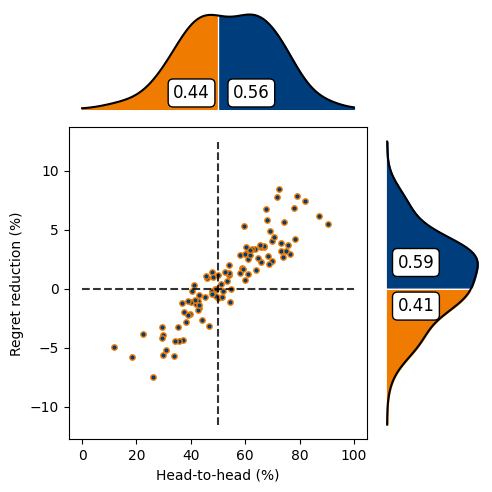

In [19]:
output_dir = DataPath + "output/"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
figure_name = output_dir + "DDR_vs_OLS"
fig_regret_h2h = Regret_H2H()
fig_regret_h2h.figure_plot_upright(win_ratio_ddr_ols_wo_noise*100,regret_reduction_ddr_ols_wo_noise*100,figure_name)